# Quelques fournitures pour le projet d'apprentissage semi-supervisé

## CIFAR-10

Il vous est demandé pour ce projet d'utiliser les données de la base de données CIFAR-10, que vous pouvez récupérer avec les quelques lignes ci-dessous. Cette base de données est constituée des 10 classes suivantes : 


A vous de partager cette base en données labellisées et non labellisées en fonction des expériences que vous mènerez !

In [1]:
!pip install tensorflow
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## RandAugment

Pour implémenter l'augmentation forte dans FixMatch, vous aurez besoin d'une politique d'augmentation de données apprise par renforcement. La méthode RandAugment a été implémentée dans la bibliothèque imgaug, voici comment l'utiliser

In [2]:
!pip uninstall --yes imgaug
!pip install imgaug==0.4.0

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)


In [22]:
import imgaug.augmenters as iaa
aug_strong = iaa.RandAugment(n=2, m=9)
aug_weak = iaa.RandAugment(n = 2, m = 0)

def randaugment_weak(img):
  return aug_weak(images=img)


def randaugment_strong(img):
  return aug_strong(images=img)

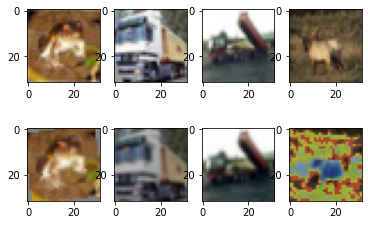

In [23]:
import matplotlib.pyplot as plt

# Application de RandAugment aux 4 premières images de la base d'entraînement
aug_img = randaugment(x_train[0:4])

# Affichage des images originales (ligne du haut) et augmentées (ligne du bas)
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(x_train[i])

  plt.subplot(2,4, i+5)
  plt.imshow(aug_img[i])

## Réseau fourni

Afin d'obtenir des résultats comparables, tout le monde devra utiliser le même réseau, que voici :

In [36]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(32,32,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 96)          55392     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 4, 96)        

## Mode uniquement supervisé

### Avec toutes les données d'entraînement

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics= ['accuracy']
)

history = model.fit(x_train, 
                    y_train,
              epochs = 50,
              batch_size= 16,          
)

Epoch 1/50
3125/3125 [==============================] - 92s 29ms/step - loss: 1.5226 - accuracy: 0.4675
Epoch 2/50
3125/3125 [==============================] - 90s 29ms/step - loss: 1.0965 - accuracy: 0.6138
Epoch 3/50
3125/3125 [==============================] - 88s 28ms/step - loss: 0.9140 - accuracy: 0.6786
Epoch 4/50
3125/3125 [==============================] - 87s 28ms/step - loss: 0.7801 - accuracy: 0.7269
Epoch 5/50
2716/3125 [=========================>....] - ETA: 11s - loss: 0.6652 - accuracy: 0.7659

## Début Fix Match

In [26]:
from sklearn.model_selection import train_test_split

x_train_weak_augmented = randaugment(x_train)

x_train_supervised, x_train_unsupervised, y_train_supervised, y_train_unsupervised = train_test_split(x_train, y_train, test_size=43750, random_state=1)

x_train_weak_augmented_supervised = randaugment_weak(x_train_supervised)
x_train_weak_augmented_unsupervised = randaugment_weak(x_train_unsupervised)

x_train_strong_augmented_supervised = randaugment_strong(x_train_supervised)
x_train_strong_augmented_unsupervised = randaugment_strong(x_train_unsupervised)


print(x_train_supervised.shape, x_train_unsupervised.shape)

(6250, 32, 32, 3) (43750, 32, 32, 3)


In [30]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy as cross_entropy

model.predict(x_train_weak_augmented_supervised)



196/196 [==============================] - 3s 17ms/step


array([[4.73273053e-11, 1.27140624e-11, 9.99807060e-01, ...,
        1.67861284e-17, 9.40542577e-06, 1.81169977e-04],
       [3.65896483e-07, 5.71372816e-08, 9.95024502e-01, ...,
        3.10378286e-11, 1.13796072e-04, 3.78294825e-03],
       [7.94396826e-10, 4.11039025e-09, 9.18355286e-01, ...,
        3.06664970e-16, 7.43776909e-05, 8.13894346e-02],
       ...,
       [1.58614608e-10, 1.88968716e-10, 9.03142989e-01, ...,
        6.51494223e-12, 2.25831263e-06, 2.30234014e-04],
       [9.18215115e-10, 4.52583887e-10, 9.99971867e-01, ...,
        3.57587867e-14, 5.02690284e-07, 2.69544089e-05],
       [9.90250763e-12, 2.09857687e-11, 9.99989271e-01, ...,
        3.71472503e-18, 1.82617470e-07, 1.02683352e-05]], dtype=float32)